# Correlation Analysis

In this notebook, I nowcast indicators of the **European Innovation Scoreboard** using GitHub data.

I examine how three different variables, the number of user accounts, projects and their spatial diversity, are correlated with the EIS dimensions.

#### Some initial results:

As shown in the notebook, the number of created projects correlates better than the number of user accounts with the EIS dimensions. Moreover, the preliminary analysis indicates a strong correlation between the “Research Systems”, “Human Resources” and “Innovation-friendly Environment” dimensions with the rate of project creation on GitHub.

Regarding the diversity index, it was calculated for EU countries based on the number of user registrations and created project in each city. The diversity index of each country was then correlated with its EIS dimensions. As it is shown below, countries with higher diversity (that is, where a high number of projects was created in multiple cities) is positively and strongly associated with many EIS dimensions such as “Research Systems” and “Human Resources”. Moreover, there is a noticeable overlap between the results when using the diversity index and the number of projects created on the platform.

**Note**: The timeframe of the analysis is 2009-2016.

In [1]:
import glob
import skbio
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
from collections import defaultdict

import sys
sys.path.append('../src/')
from utils import *

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rc('ytick',labelsize=14)

In [3]:
eis = pd.read_excel('../data/raw/EIS2017_database.xlsx', header=[2])
github_data = pd.concat([pd.read_csv(filename) for filename in glob.glob('../data/raw/github_data/*')])

In [4]:
github_data['user_country_code'] = github_data.user_country_code.apply(change_cc)

# keep only EU github projects 
github_data = github_data[github_data['user_country_code'].isin([x.lower() for x in eis.index.levels[0]])]

# Create columns with only the year
github_data['user_year'] = github_data.user_creation_date.apply(lambda x: x[:4])
github_data['project_year'] = github_data.project_creation_date.apply(lambda x: x[:4])

In [5]:
github_data.shape

(7038127, 19)

## EIS indicators - Github user registrations and projects creation

In [6]:
def calc_corr(ind, cc, data):
    """Calculate Pearson correlation on a data subset."""
    return np.corrcoef(np.array(data.loc[(ind, cc)].iloc[:, 0]).astype(float), np.array(data.loc[(ind, cc)].iloc[:, 1]).astype(float))[0][1]

In [7]:
# EIS indicators
main_indicators = ['Summary Innovation Index', 'Human resources', 'Research systems', 
                   'Innovation-friendly environment', 'Finance and support', 'Firm investments', 
                   'Innovators', 'Linkages', 'Intellectual assets', 'Employment impacts', 'Sales impacts']

eu_cc = set([cc for cc in github_data['user_country_code']])

In [8]:
def country_users(cc, data):
    """Slice the github data by country code and select users per year."""
    dataset = data[data.user_country_code==cc]
    users = dataset.drop_duplicates('user_id').groupby('user_year').count()['user_id']
    users = users.loc['2009':'2016']
    users.reset_index(inplace=True, drop=True)
    return users

def country_projects(cc, data):
    """Slice the github data by country code and select projects per year."""
    dataset = data[data.user_country_code==cc]
    projects = dataset.drop_duplicates('project_id').groupby('project_year').count()['project_id']
    projects = projects.loc['2009':'2016']
    projects.reset_index(inplace=True, drop=True)
    return projects

def select_eis(cc, eis_col):
    """Slice EIS data by country code."""
    e = eis.loc[cc.upper(), [col for col in eis.columns if eis_col in col]].T
    e = e.iloc[[-1,-2,-3,-4,-5,-6,-7, -8], ]
    e.reset_index(inplace=True, drop=True)
    return e

def data_transformer(cc, indicator, data, users=True):
    if users:    
        df = pd.concat([select_eis(cc, indicator), country_users(cc, data)], axis=1)
    else:
        df = pd.concat([select_eis(cc, indicator), country_projects(cc, data)], axis=1)
        
    df['Indicator'] = indicator
    df['Country'] = cc
    df.rename(index=str, inplace=True, columns={df.columns[0]:'ind_val'})
    df.set_index(np.array([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]), inplace=True)

    return df

def corr_transformer(data):
    df = pd.concat(d for d in data)
    df.set_index(['Indicator', 'Country'], inplace=True)
    d = {}
    for cc in eu_cc:
        m = {}
        for ind in main_indicators:
            m[ind] = calc_corr(ind, cc, df)

        d[cc] = m
        
    correlations = pd.DataFrame.from_dict(d).T
    return correlations.T

In [9]:
%%time
users = [[data_transformer(cc, ind, github_data) for cc in eu_cc] for ind in main_indicators]
corr_users = corr_transformer(flatten_lists(users))

projects = [[data_transformer(cc, ind, github_data, users=False) for cc in eu_cc] for ind in main_indicators]
corr_proj = corr_transformer(flatten_lists(projects))

CPU times: user 11min 32s, sys: 31.9 s, total: 12min 4s
Wall time: 12min 11s


In [10]:
def barplots(data, indicator, x_pos, y_pos):
    """Draw series of barplots."""
    if x_pos+1 == data.shape[0]:
        ax = fig.add_subplot(gs[x_pos, y_pos])
        data.loc[indicator, ].plot(kind='bar', color='xkcd:sea blue', ax=ax, rot=90, width=1, edgecolor='k')
        ax.set_xticklabels([eis.loc[cc.upper(), :].index[0] if cc != 'mk' else 'FYROM' for cc in data.columns], fontsize=16)
        ax.set_title(idx, fontsize=17)
        
    else:
        ax = fig.add_subplot(gs[x_pos, y_pos])
        data.loc[indicator, ].plot(kind='bar', color='xkcd:sea blue', ax=ax, width=1, edgecolor='k')
        ax.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
        ax.set_title(indicator, fontsize=17)
    
    ax.set_ylim([-1, 1])

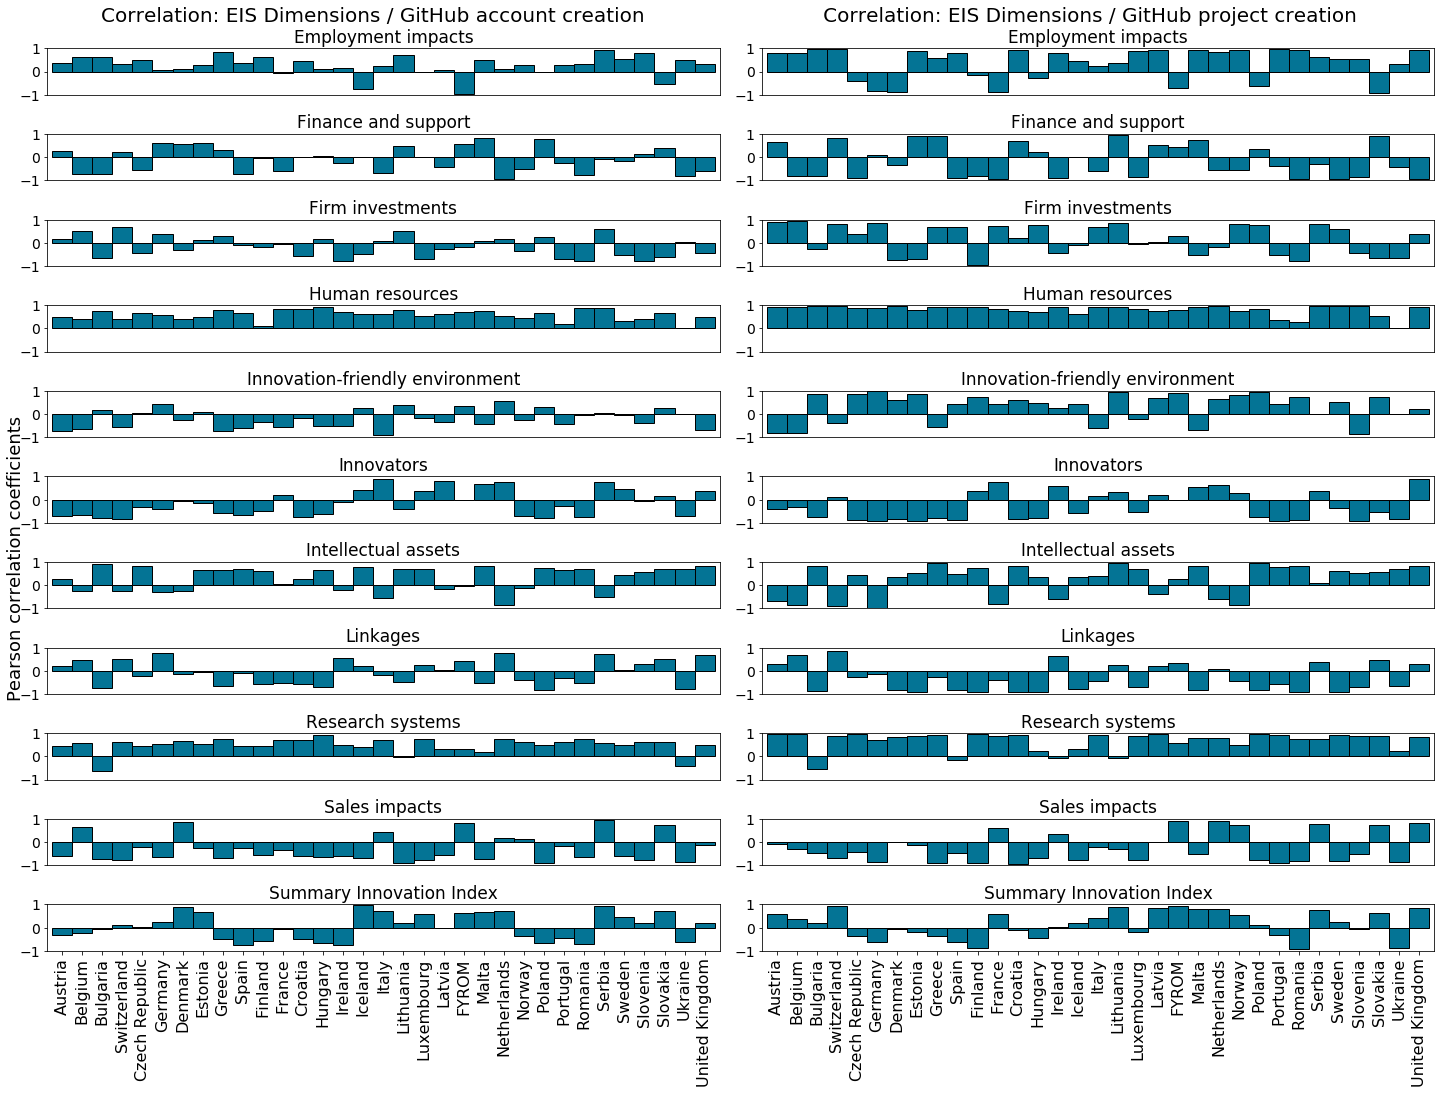

In [11]:
gs = gridspec.GridSpec(corr_proj.shape[0], 2)
fig = plt.figure(figsize=(20,15))

for i, idx in enumerate(corr_proj.index):
    barplots(corr_users, idx, i, 0)
    barplots(corr_proj, idx, i, 1)

fig.text(-0.001, 0.5, 'Pearson correlation coefficients', va='center', rotation='vertical', fontsize=18)
plt.suptitle('Correlation: EIS Dimensions / GitHub account creation                            Correlation: EIS Dimensions / GitHub project creation', fontsize=20, y=1.01)
plt.tight_layout()

plt.savefig('../eis_indicators_gh_corr.pdf')
plt.show()

## Main indicators - Spatial diversity of Github user registrations and projects creation

In [12]:
ghd = github_data[github_data.user_city.isnull()==False]
ghd = ghd[ghd.project_year.isin(['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016'])]

In [13]:
def calc_diversity(data, users=True):
    dictionary = defaultdict(list)
    for cc in eu_cc:
        if users:
            df = data.drop_duplicates('user_id')[data.drop_duplicates('user_id').user_country_code==cc].groupby(['project_year', 'user_city']).count()['user_id']
        else:
            df = data[data.user_country_code==cc].groupby(['project_year', 'user_city']).count()['project_id']

        for idx in df.index.levels[0]:
            dictionary[cc].append(skbio.diversity.alpha.shannon(df.loc[idx, :]))
            
    if users:
        df_dict = pd.DataFrame.from_dict(dictionary, orient='index').T
    else:
        df_dict = pd.DataFrame.from_dict(dictionary)
    return df_dict

def calc_div_corr(df):
    d = {}
    for ind in main_indicators:
        m = {}
        for cc in eu_cc:
            m[cc] = np.corrcoef(np.array([v[0] for v in select_eis(cc, ind).values]), np.array(df[cc]))[0][1]
        d[ind] = m
    return pd.DataFrame(d).T

In [14]:
div_proj = calc_div_corr(calc_diversity(ghd, users=False))
div_users = calc_div_corr(calc_diversity(ghd))

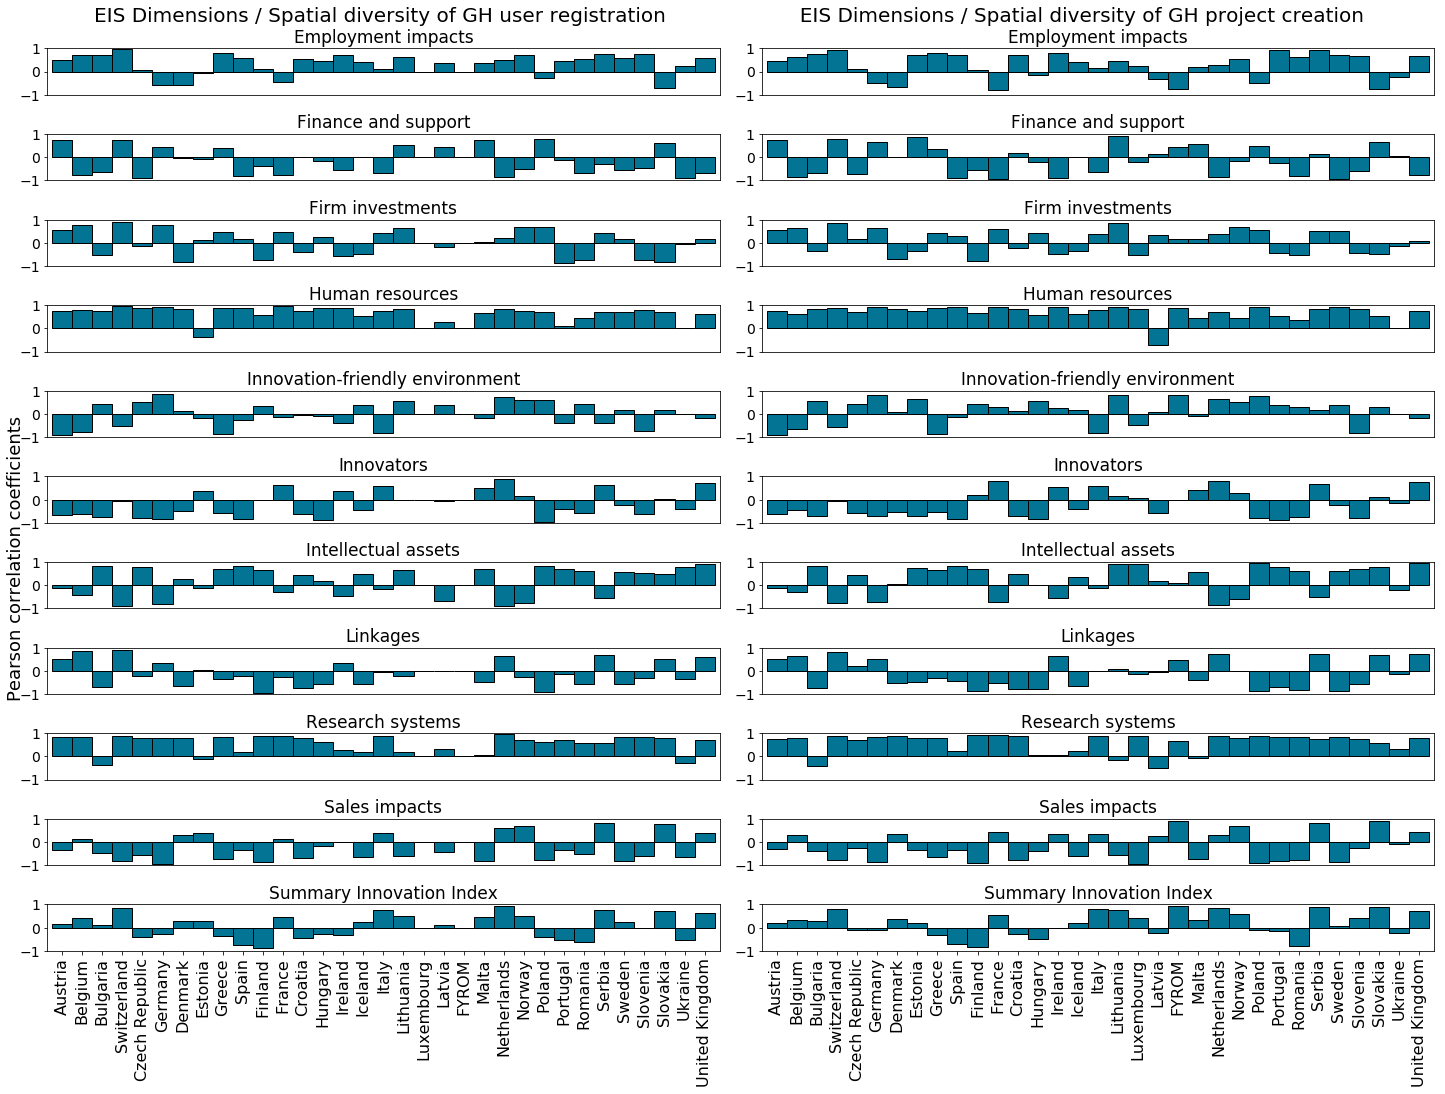

In [15]:
gs = gridspec.GridSpec(div_users.shape[0], 2)
fig = plt.figure(figsize=(20,15))

for i, idx in enumerate(div_users.index):
    
    barplots(div_proj, idx, i, 1)
    barplots(div_users, idx, i, 0)
    
fig.text(-0.001, 0.5, 'Pearson correlation coefficients', va='center', rotation='vertical', fontsize=18)
plt.suptitle('EIS Dimensions / Spatial diversity of GH user registration                     EIS Dimensions / Spatial diversity of GH project creation', fontsize=20, y=1.01)

plt.tight_layout()

plt.savefig('../diversity_corr.pdf')

plt.show()